In [1]:
import pandas as pd
import numpy as np
import cv2 as cv
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import scatter_matrix
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import itertools
from sklearn.preprocessing import LabelEncoder
from IPython.display import display
import seaborn as sns
import xgboost as xgb
import time
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from matplotlib.pylab import rcParams


Wczytanie zbioru danych

In [2]:
data= pd.read_csv("Car_Prices_Poland_Kaggle.csv")
print(data.info())
print(data.shape)
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117927 entries, 0 to 117926
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Unnamed: 0       117927 non-null  int64 
 1   mark             117927 non-null  object
 2   model            117927 non-null  object
 3   generation_name  87842 non-null   object
 4   year             117927 non-null  int64 
 5   mileage          117927 non-null  int64 
 6   vol_engine       117927 non-null  int64 
 7   fuel             117927 non-null  object
 8   city             117927 non-null  object
 9   province         117927 non-null  object
 10  price            117927 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 9.9+ MB
None
(117927, 11)


,Unnamed: 0,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
0,0,opel,combo,gen-d-2011,2015,139568,1248,Diesel,Janki,Mazowieckie,35900
1,1,opel,combo,gen-d-2011,2018,31991,1499,Diesel,Katowice,Śląskie,78501
2,2,opel,combo,gen-d-2011,2015,278437,1598,Diesel,Brzeg,Opolskie,27000
3,3,opel,combo,gen-d-2011,2016,47600,1248,Diesel,Korfantów,Opolskie,30800
4,4,opel,combo,gen-d-2011,2014,103000,1400,CNG,Tarnowskie Góry,Śląskie,35900


Analiza i czyszczenie zbioru danych

In [3]:

m1 = data['province'] == 'Moravian-Silesian Region'
m2 = data['province'] == 'Berlin'
m3 = data['province'] == 'Wiedeń'
m4 = data['province'] == 'Trenczyn'
m5 = data['province'] == 'Niedersachsen'
m6 = data['province'] == 'Nordrhein-Westfalen'
m7 = data['province'] == '('
m8 = data['fuel'] == 'CNG'
m9 = data['year'] < 1992
m10 = data['vol_engine'] == 1
data.loc[data['fuel'] == 'Electric', 'vol_engine'] = 1
m11 = data['vol_engine'] <= 0
mo=[m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11]
for m in mo:
    data = data.drop(data.loc[m].index)
data['province'].value_counts()
data.loc[data['fuel'] == 'Electric', 'vol_engine'] = 1

In [4]:
counts = data['model'].value_counts()
mod=data['model'].isin(counts[counts < 60].index)
data = data.drop(data.loc[mod].index)

In [6]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
z=data.where(data["mark"] == 'volkswagen').sort_values(by="vol_engine").dropna()
display(z)

,Unnamed: 0,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price,Marka,Model,Silnik,Wojewodztwo


In [5]:
def f1():
    data['Marka'] = data['mark']
    data['Model'] = data['model']
    data['Silnik'] = data['fuel']
    data['Wojewodztwo'] = data['province']
    label=LabelEncoder()
    data["mark"]=label.fit_transform(data["mark"])
    data["model"]=label.fit_transform(data["model"])
    data["fuel"]=label.fit_transform(data["fuel"])
    data["province"]=label.fit_transform(data["province"])
    data['mark']=data['mark']+1
    data['model']=data['model']+1
    data.head()
f1()


In [7]:
data.head()

,Unnamed: 0,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price,Marka,Model,Silnik,Wojewodztwo
0,0,16,83,gen-d-2011,2015,139568,1248,0,Janki,4,35900,opel,combo,Diesel,Mazowieckie
1,1,16,83,gen-d-2011,2018,31991,1499,0,Katowice,14,78501,opel,combo,Diesel,Śląskie
2,2,16,83,gen-d-2011,2015,278437,1598,0,Brzeg,6,27000,opel,combo,Diesel,Opolskie
3,3,16,83,gen-d-2011,2016,47600,1248,0,Korfantów,6,30800,opel,combo,Diesel,Opolskie
5,5,16,83,gen-d-2011,2017,121203,1598,0,Warszawa,4,51900,opel,combo,Diesel,Mazowieckie


In [8]:

model=data[['mark','Marka','model','Model']]
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
model=model.sort_values(by='model').drop_duplicates()
model.to_csv('model_data2.txt', sep='\t', index=False)



In [9]:
df=data
df.head()

,Unnamed: 0,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price,Marka,Model,Silnik,Wojewodztwo
0,0,16,83,gen-d-2011,2015,139568,1248,0,Janki,4,35900,opel,combo,Diesel,Mazowieckie
1,1,16,83,gen-d-2011,2018,31991,1499,0,Katowice,14,78501,opel,combo,Diesel,Śląskie
2,2,16,83,gen-d-2011,2015,278437,1598,0,Brzeg,6,27000,opel,combo,Diesel,Opolskie
3,3,16,83,gen-d-2011,2016,47600,1248,0,Korfantów,6,30800,opel,combo,Diesel,Opolskie
5,5,16,83,gen-d-2011,2017,121203,1598,0,Warszawa,4,51900,opel,combo,Diesel,Mazowieckie


Wykresy

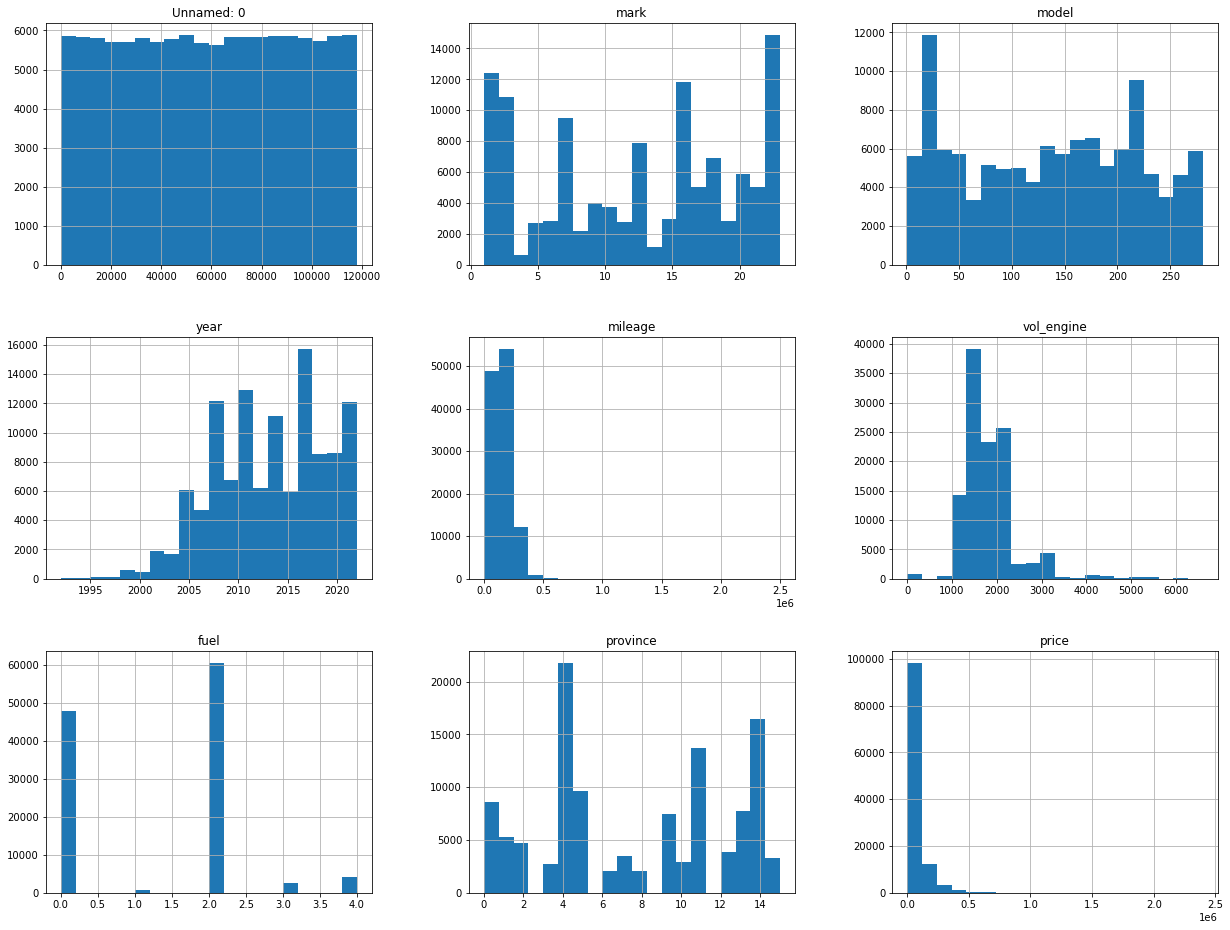

In [43]:
df.hist(bins=20, figsize=(21,16))
plt.show()

In [ ]:
df["mileage_cat"] = pd.cut(df["mileage"],
                           bins=[0., 50000, 100000, 150000, 200000, 3000000],
                           labels=[1, 2, 3, 4, 5])

c:\Users\patry\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


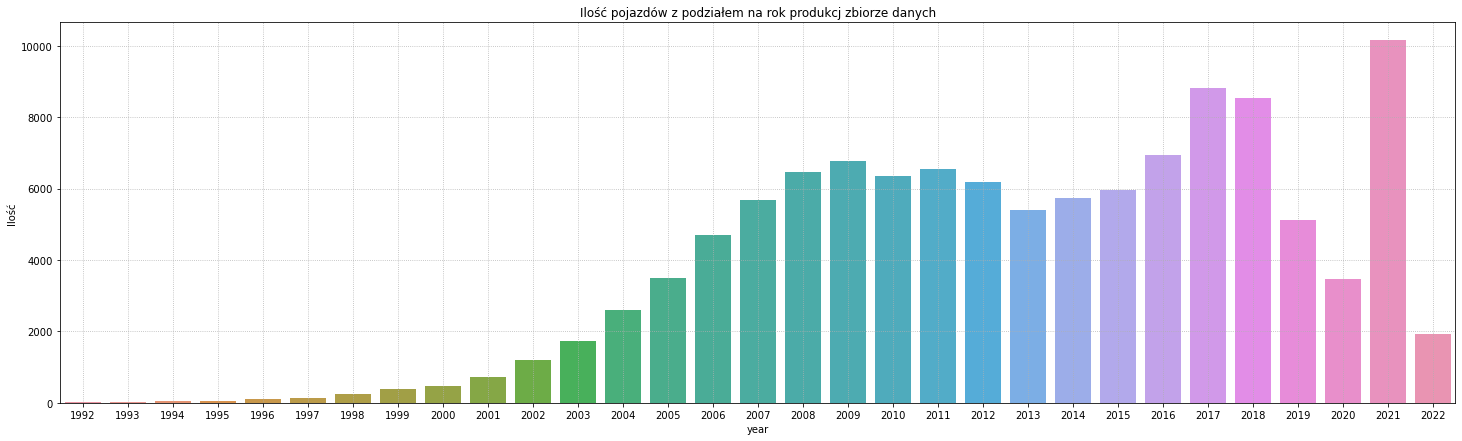

In [62]:
def w1():    
    plt.figure(figsize=(25,7))
    plt.title("Ilość pojazdów z podziałem na rok produkcj zbiorze danych")
    sns.countplot(df['year'])
    plt.ylabel("Ilość")
    plt.grid(linestyle="dotted")
    plt.show()
w1()

c:\Users\patry\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


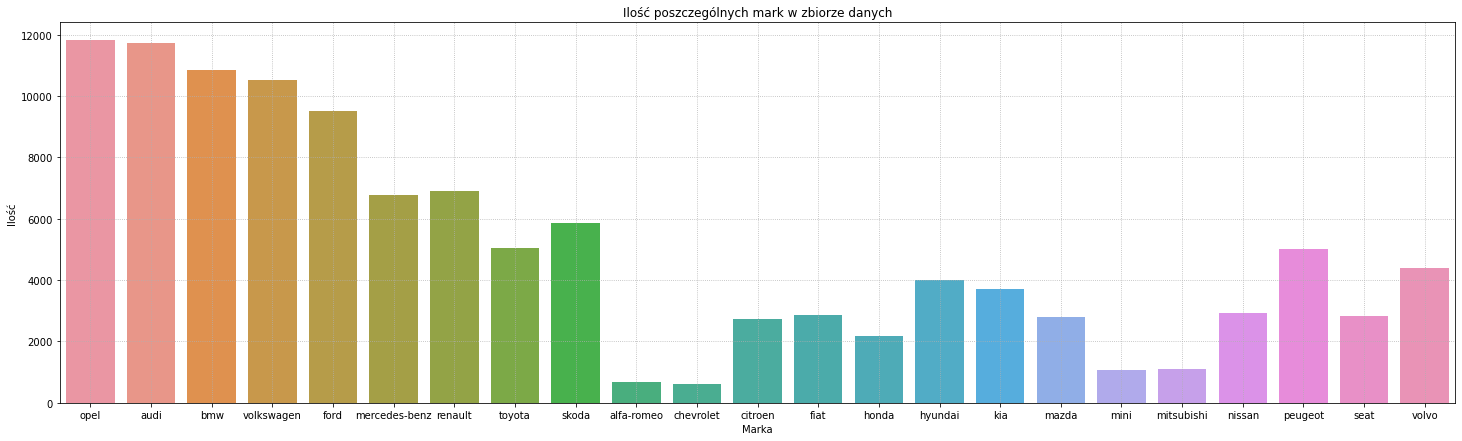

In [63]:
def w2():
    plt.figure(figsize=(25,7))
    plt.title("Ilość poszczególnych mark w zbiorze danych")
    sns.countplot(df['Marka'])
    plt.ylabel("Ilość")
    plt.grid(linestyle="dotted")
    plt.show()
w2()

c:\Users\patry\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


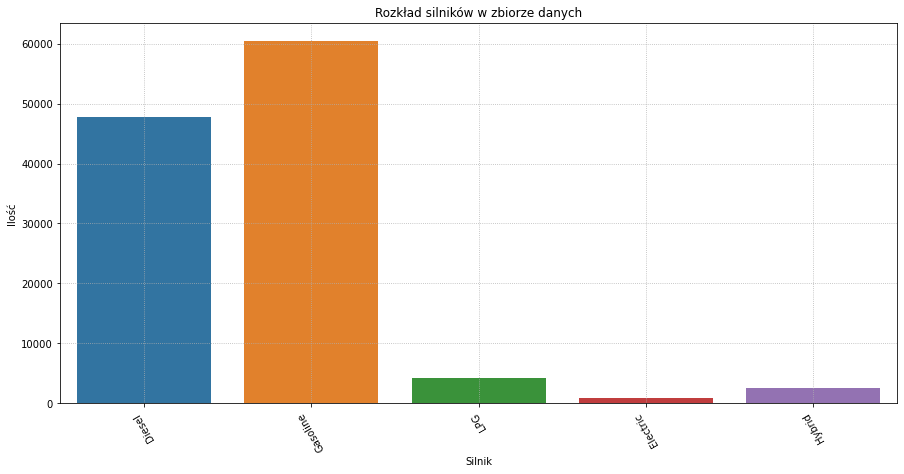

In [64]:
def w3():
    plt.figure(figsize=(15,7))
    plt.title("Rozkład silników w zbiorze danych")
    sns.countplot(df["Silnik"])
    plt.ylabel("Ilość")
    plt.xticks(rotation=120)
    plt.grid(linestyle="dotted")
    plt.show()
w3()

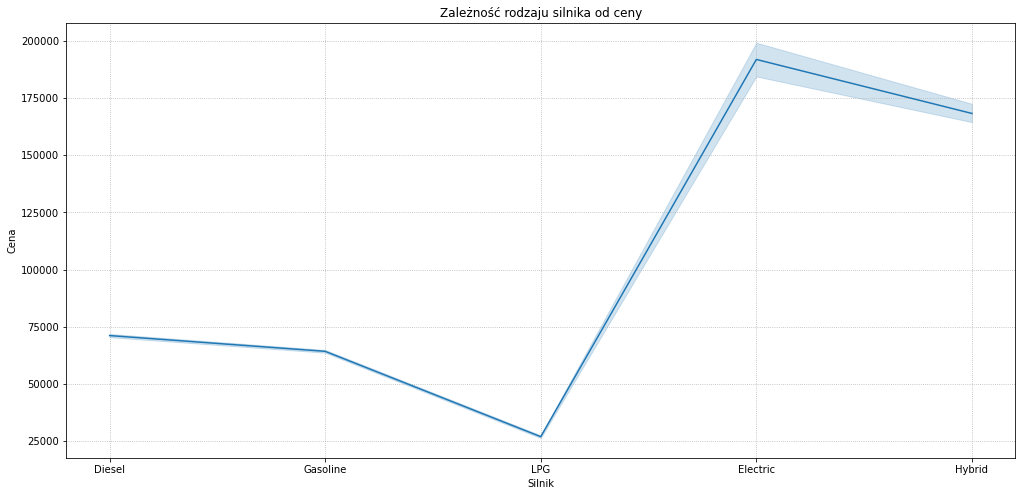

In [65]:
def w4():
    plt.figure(figsize=(17,8))
    plt.title("Zależność rodzaju silnika od ceny")
    sns.lineplot(data=df,x="Silnik",y="price")
    plt.ylabel("Cena")
    plt.grid(linestyle="dotted")
    plt.show()
w4()


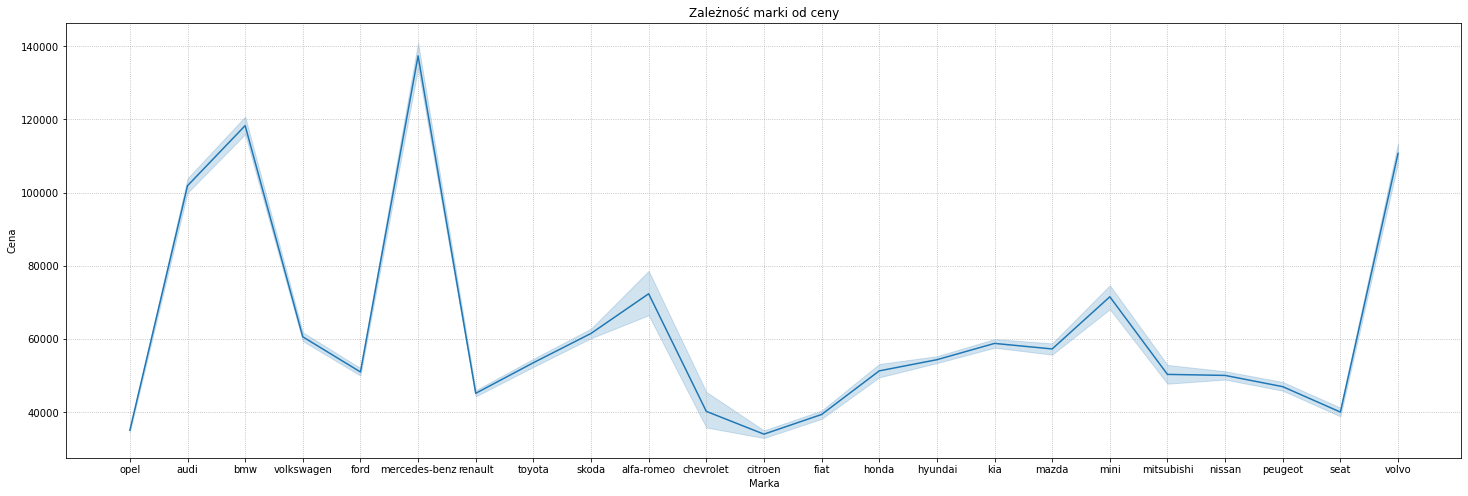

In [66]:
def w4():
    plt.figure(figsize=(25,8))
    plt.title("Zależność marki od ceny")
    sns.lineplot(data=df,x="Marka",y="price")
    plt.ylabel("Cena")
    plt.grid(linestyle="dotted")
    plt.show()
w4()



In [67]:
data.columns

Index(['Unnamed: 0', 'mark', 'model', 'generation_name', 'year', 'mileage',
       'vol_engine', 'fuel', 'city', 'province', 'price', 'Marka', 'Model',
       'Silnik', 'Wojewodztwo'],
      dtype='object')

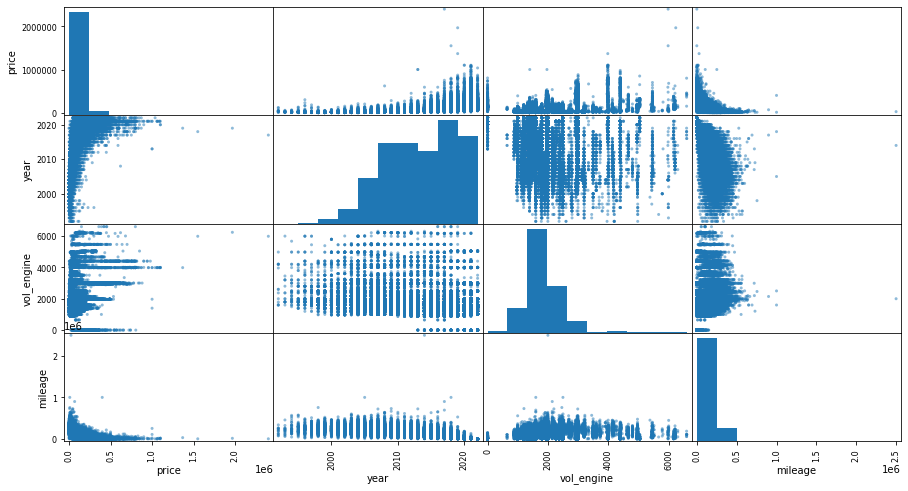

In [68]:
att = ["price", "year", "vol_engine", "mileage"]
scatter_matrix(df[att], figsize=(15, 8));

Dodac kolerlacje i 

In [10]:
def f2():
    data.drop(columns=["Unnamed: 0"],axis=1 ,inplace=True)
    data.drop(columns=["generation_name"],axis=1 ,inplace=True)
    data.drop(columns=["city"],axis=1 ,inplace=True)
    data.drop(columns=["Marka"],axis=1 ,inplace=True)
    data.drop(columns=["Model"],axis=1 ,inplace=True)
    data.drop(columns=["Silnik"],axis=1 ,inplace=True)
    data.drop(columns=["Wojewodztwo"],axis=1 ,inplace=True)
  #  data.drop(columns=["mileage_cat"],axis=1 ,inplace=True)
f2()

In [72]:
data.describe()

,mark,model,year,mileage,vol_engine,fuel,province,price
count,115877.000000,115877.000000,115877.000000,1.158770e+05,115877.000000,115877.000000,115877.00000,1.158770e+05
mean,12.429818,135.675475,2012.947082,1.414324e+05,1807.980574,1.262684,7.64943,6.897309e+04
std,7.082487,82.388637,5.548550,9.159543e+04,618.975739,1.131470,4.76685,8.208434e+04
min,1.000000,1.000000,1992.000000,0.000000e+00,1.000000,0.000000,0.00000,5.000000e+02
25%,6.000000,55.000000,2009.000000,6.816800e+04,1461.000000,0.000000,4.00000,2.100000e+04
50%,12.000000,141.000000,2013.000000,1.470000e+05,1796.000000,2.000000,7.00000,4.170000e+04
75%,18.000000,208.000000,2018.000000,2.030000e+05,1995.000000,2.000000,12.00000,8.200000e+04
max,23.000000,281.000000,2022.000000,2.500000e+06,6600.000000,4.000000,15.00000,2.399900e+06


In [71]:
data.corr()

,mark,model,year,mileage,vol_engine,fuel,province,price
mark,1.000000,0.141548,0.033411,-0.031428,-0.262004,0.074171,0.003279,-0.147439
model,0.141548,1.000000,0.067677,-0.024986,0.110113,-0.060020,0.006417,0.144682
year,0.033411,0.067677,1.000000,-0.749573,-0.147026,-0.029821,0.036809,0.613763
mileage,-0.031428,-0.024986,-0.749573,1.000000,0.207675,-0.247627,-0.052637,-0.546602
vol_engine,-0.262004,0.110113,-0.147026,0.207675,1.000000,-0.167841,-0.034080,0.313946
fuel,0.074171,-0.060020,-0.029821,-0.247627,-0.167841,1.000000,0.012381,-0.038114
province,0.003279,0.006417,0.036809,-0.052637,-0.034080,0.012381,1.000000,0.030469
price,-0.147439,0.144682,0.613763,-0.546602,0.313946,-0.038114,0.030469,1.000000


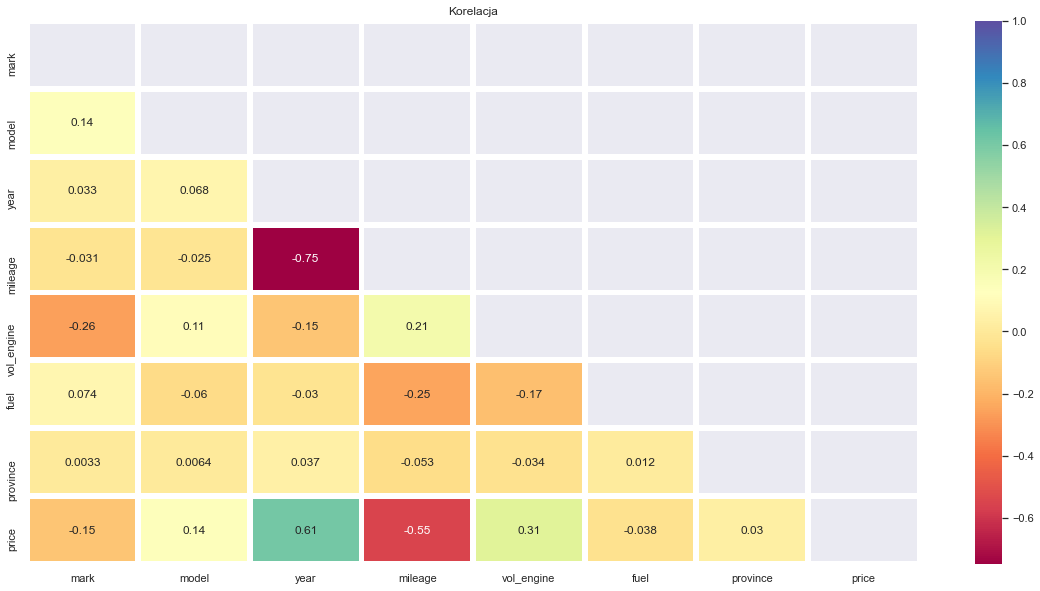

In [74]:
def corr():
    correlation_matrix = data.corr()
    sns.set(rc={'figure.figsize':(20,10)}) 
    plt.title("Korelacja")
    mask = np.triu(np.ones_like(correlation_matrix), k=0) 
    sns.heatmap(correlation_matrix, annot=True, cmap = 'Spectral', linewidths=5, mask=mask, vmax=1)
    pass
corr()

Uczenie maszynowe

1. LinearRegression()

In [11]:
X = data.drop(['price'], axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=42)
print(' Train : ', X_train.shape, y_train.shape,'\n', 'Test' , X_test.shape, y_test.shape)

 Train :  (92701, 7) (92701,) 
 Test (23176, 7) (23176,)


In [92]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


lnr = LinearRegression()

lnr.fit(X_train, y_train)

y_pred = lnr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse}, MAE: {mae}, R^2: {r2}')

MSE: 2707786224.001703, MAE: 31738.296335566443, R^2: 0.5922400599249891


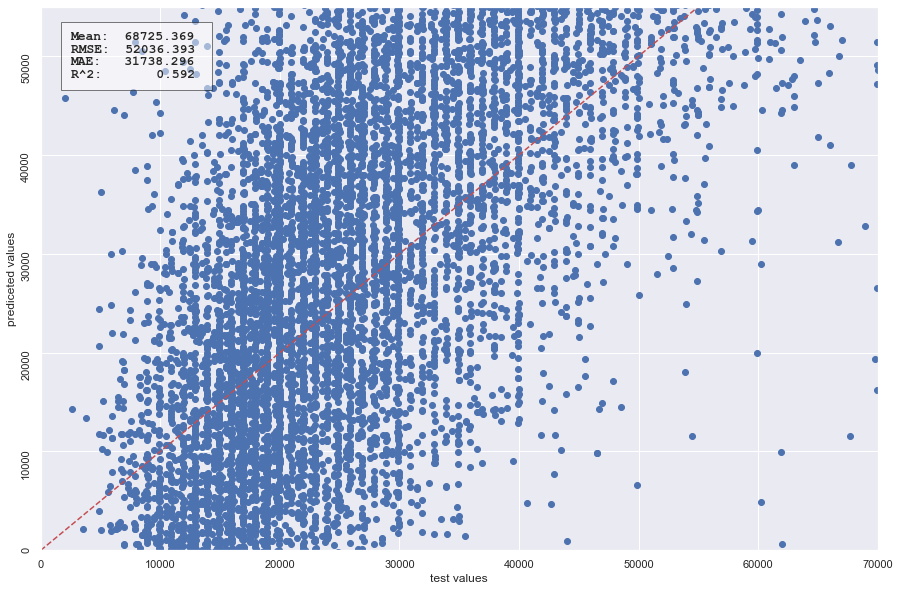

In [93]:
def w1():
       
        max = 55000

        sns.set(rc={'figure.figsize':(15,10)})
        plt.xlim(0,70000)
        plt.ylim(0,max)
        plt.scatter(y_test,y_pred)
        plt.yticks(rotation="90")
        plt.xlabel("test values")
        plt.ylabel("prediceted values")
        plt.plot([0,max],[0,max],'r--')

        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
                #plt.title(str(title).upper(), font={'size':16})
        t1, t2, t3, t4 = "Mean:", "RMSE:", "MAE:", "R^2:"
        s1, s2, s3, s4 = format(y_pred.mean(),'.3f'), format(rmse,'.3f'), format(mae,'.3f'), format(r2,'.3f')
        plt.annotate(f"{t1} {s1:>10} \n{t2} {s2:>10} \n{t3} {s3:>11} \n{t4} {s4:>11}", [2500,max*.87],
                                font={'size':13, 'family':'courier new', 'weight':'bold'},
                                bbox={'facecolor': 'white', 'edgecolor' : 'black', 'alpha': 0.5, 'pad': 10})
        plt.title="LinearRegression"
        plt.show()
w1()

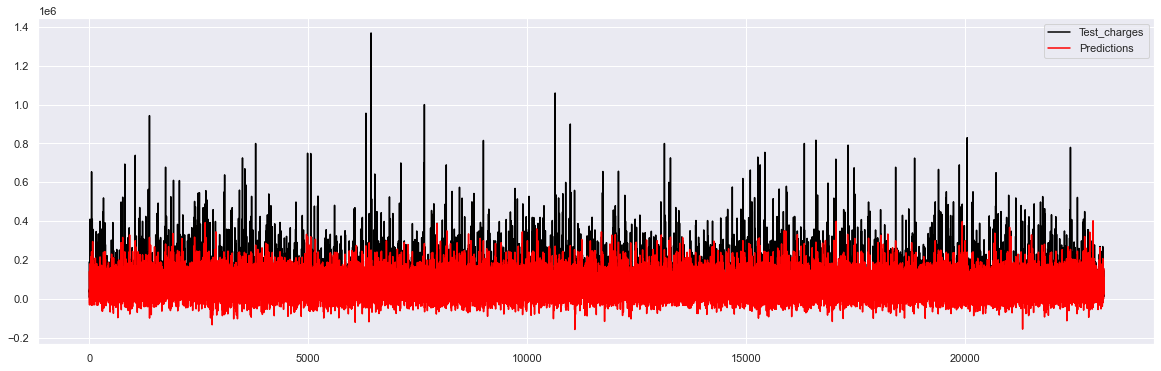

In [94]:
def pred_plot():
    plt.figure(figsize=(20,6))
    plt.plot(np.arange(len(y_test)), y_test, color='black', label='Test_charges')
    plt.plot(np.arange(len(y_pred)), y_pred, color='red' ,label='Predictions')
    plt.legend()
    plt.title="LinearRegression"
    plt.show()
pred_plot()

2. DecisionTreeRegressor

In [95]:

model_dtr=DecisionTreeRegressor()
model_dtr
model_dtr.fit(X_train,y_train)
y_pred=model_dtr.predict(X_test)
print("wyniki medelu DecisionTreeRegressor() :")
print('Score R2 : ',model_dtr.score(X_test,y_test))
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
mae=mean_absolute_error(y_test,y_pred)
print('RMSE : ',rmse)
print('MAE', mae)

wyniki medelu DecisionTreeRegressor() :
Score R2 :  0.9182013204199508
RMSE :  23306.553460871528
MAE 10176.43561032166


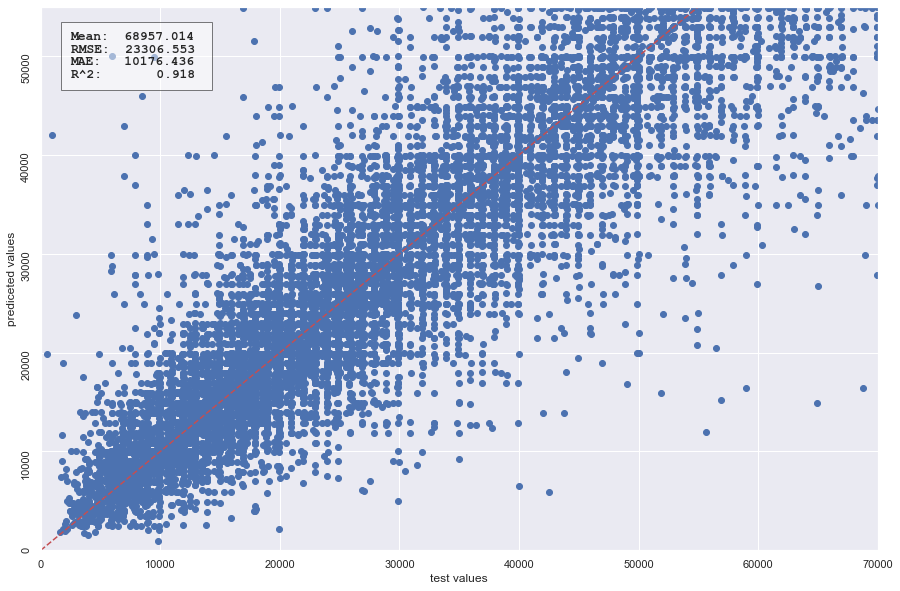

In [96]:
w1()

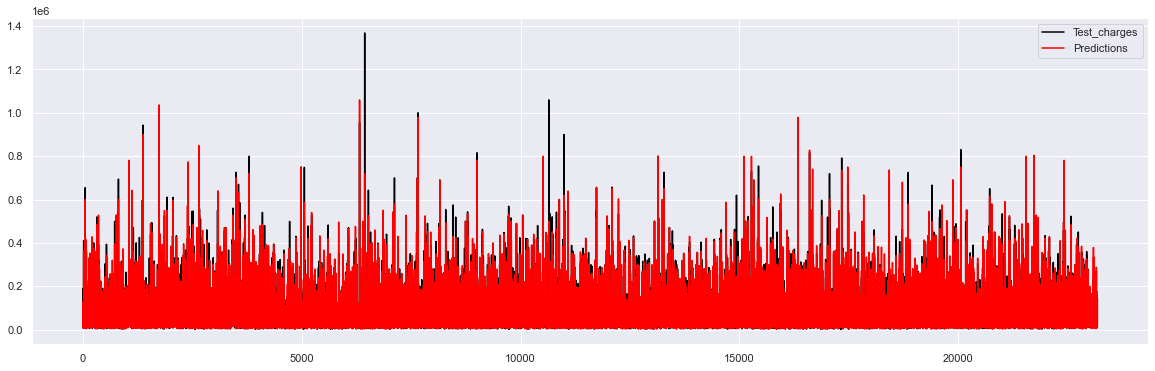

In [97]:
pred_plot()

3. RandomForestRegressor()

In [114]:

rfr=RandomForestRegressor()
rfr.fit(X_train,y_train)
y_pred=rfr.predict(X_test)
print("wyniki medelu RandomForestRegressor() :")
print('Score R2 : ',rfr.score(X_test,y_test))
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
mae=mean_absolute_error(y_test,y_pred)
print('RMSE : ',rmse)
print('MAE', mae)

wyniki medelu RandomForestRegressor() :
Score R2 :  0.9426151528440034
RMSE :  19521.065714990484
MAE 8280.656646004732


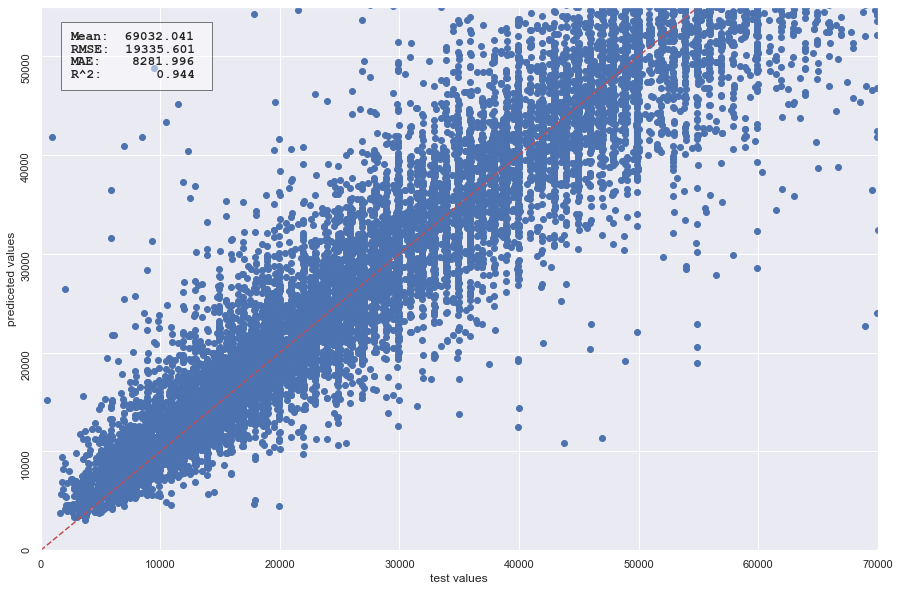

In [99]:
w1()

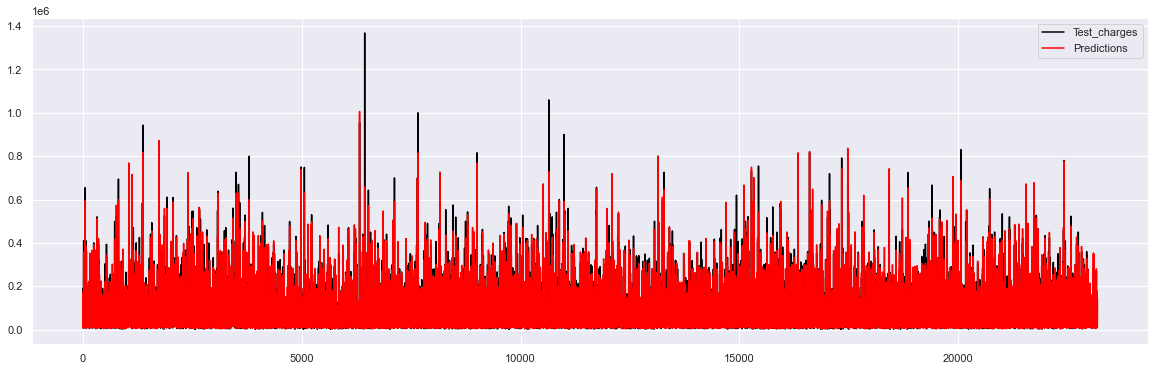

In [100]:
pred_plot()

Dobieranie najlepszych hiperparametrów dla RandomForestRegressor()

In [113]:
#RANDOMIZEDSEARCHCV 
params={
    "n_estimators": [10, 50,80, 100,120, 200],
    "max_depth": [5, 10, 15,18, 20,24,25 , None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", "log2", None]
    
}
l7=[]
model_rfr=RandomForestRegressor()
random_search=RandomizedSearchCV(model_rfr, param_distributions=params,random_state=42,n_iter=10, cv=5, n_jobs=-1)
random_search.fit(X_train, y_train)
y_pred=random_search.predict(X_test)
print('Score R2 : ',random_search.score(X_test,y_test))
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
mae=mean_absolute_error(y_test,y_pred)
print('RMSE : ',rmse)
print('MAE', mae)
print('best_params: ',random_search.best_params_)
print("================")
l7.append([ rmse,'MAE :', mae,'best_params: ',random_search.best_params_, 'params_estimator',random_search.best_estimator_] )


Score R2 :  0.9445518170850753
RMSE :  19188.833215153118
MAE 8399.53373192338
best_params:  {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 24}


4. XGBRegressor()

In [12]:
#model próbny bez hiperparametrów
model_x1=xgb.XGBRegressor(n_estimator= 150, max_depth= 8, learning_rate =0.2, gamma =0.01, colsample_bytree= 0.5)
model_x1
model_x1.fit(X_train,y_train)
y_pred=model_x1.predict(X_test)
print("wyniki medelu XGBRegressor() :")
print('Score R2 : ',model_x1.score(X_test,y_test))
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
mae=mean_absolute_error(y_test,y_pred)
print('RMSE : ',rmse)
print('MAE', mae)

[00:15:57] WARNING: ..\src\learner.cc:576: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


wyniki medelu XGBRegressor() :
Score R2 :  0.943229591695523
RMSE :  19416.275146274038
MAE 9010.063461911568


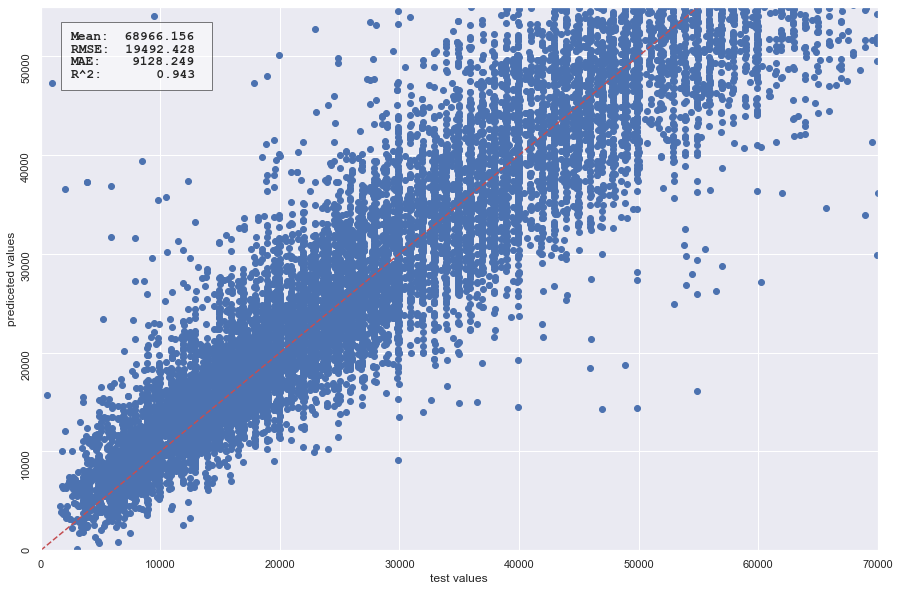

In [102]:
w1()

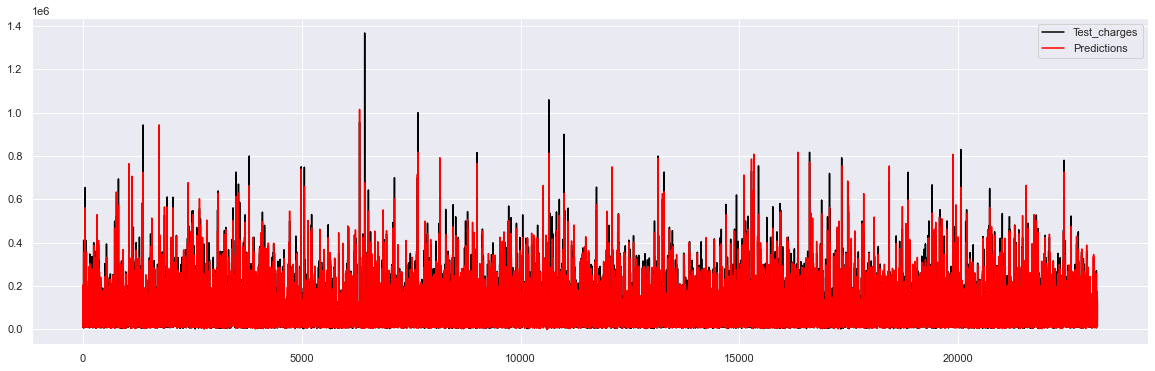

In [103]:

pred_plot()

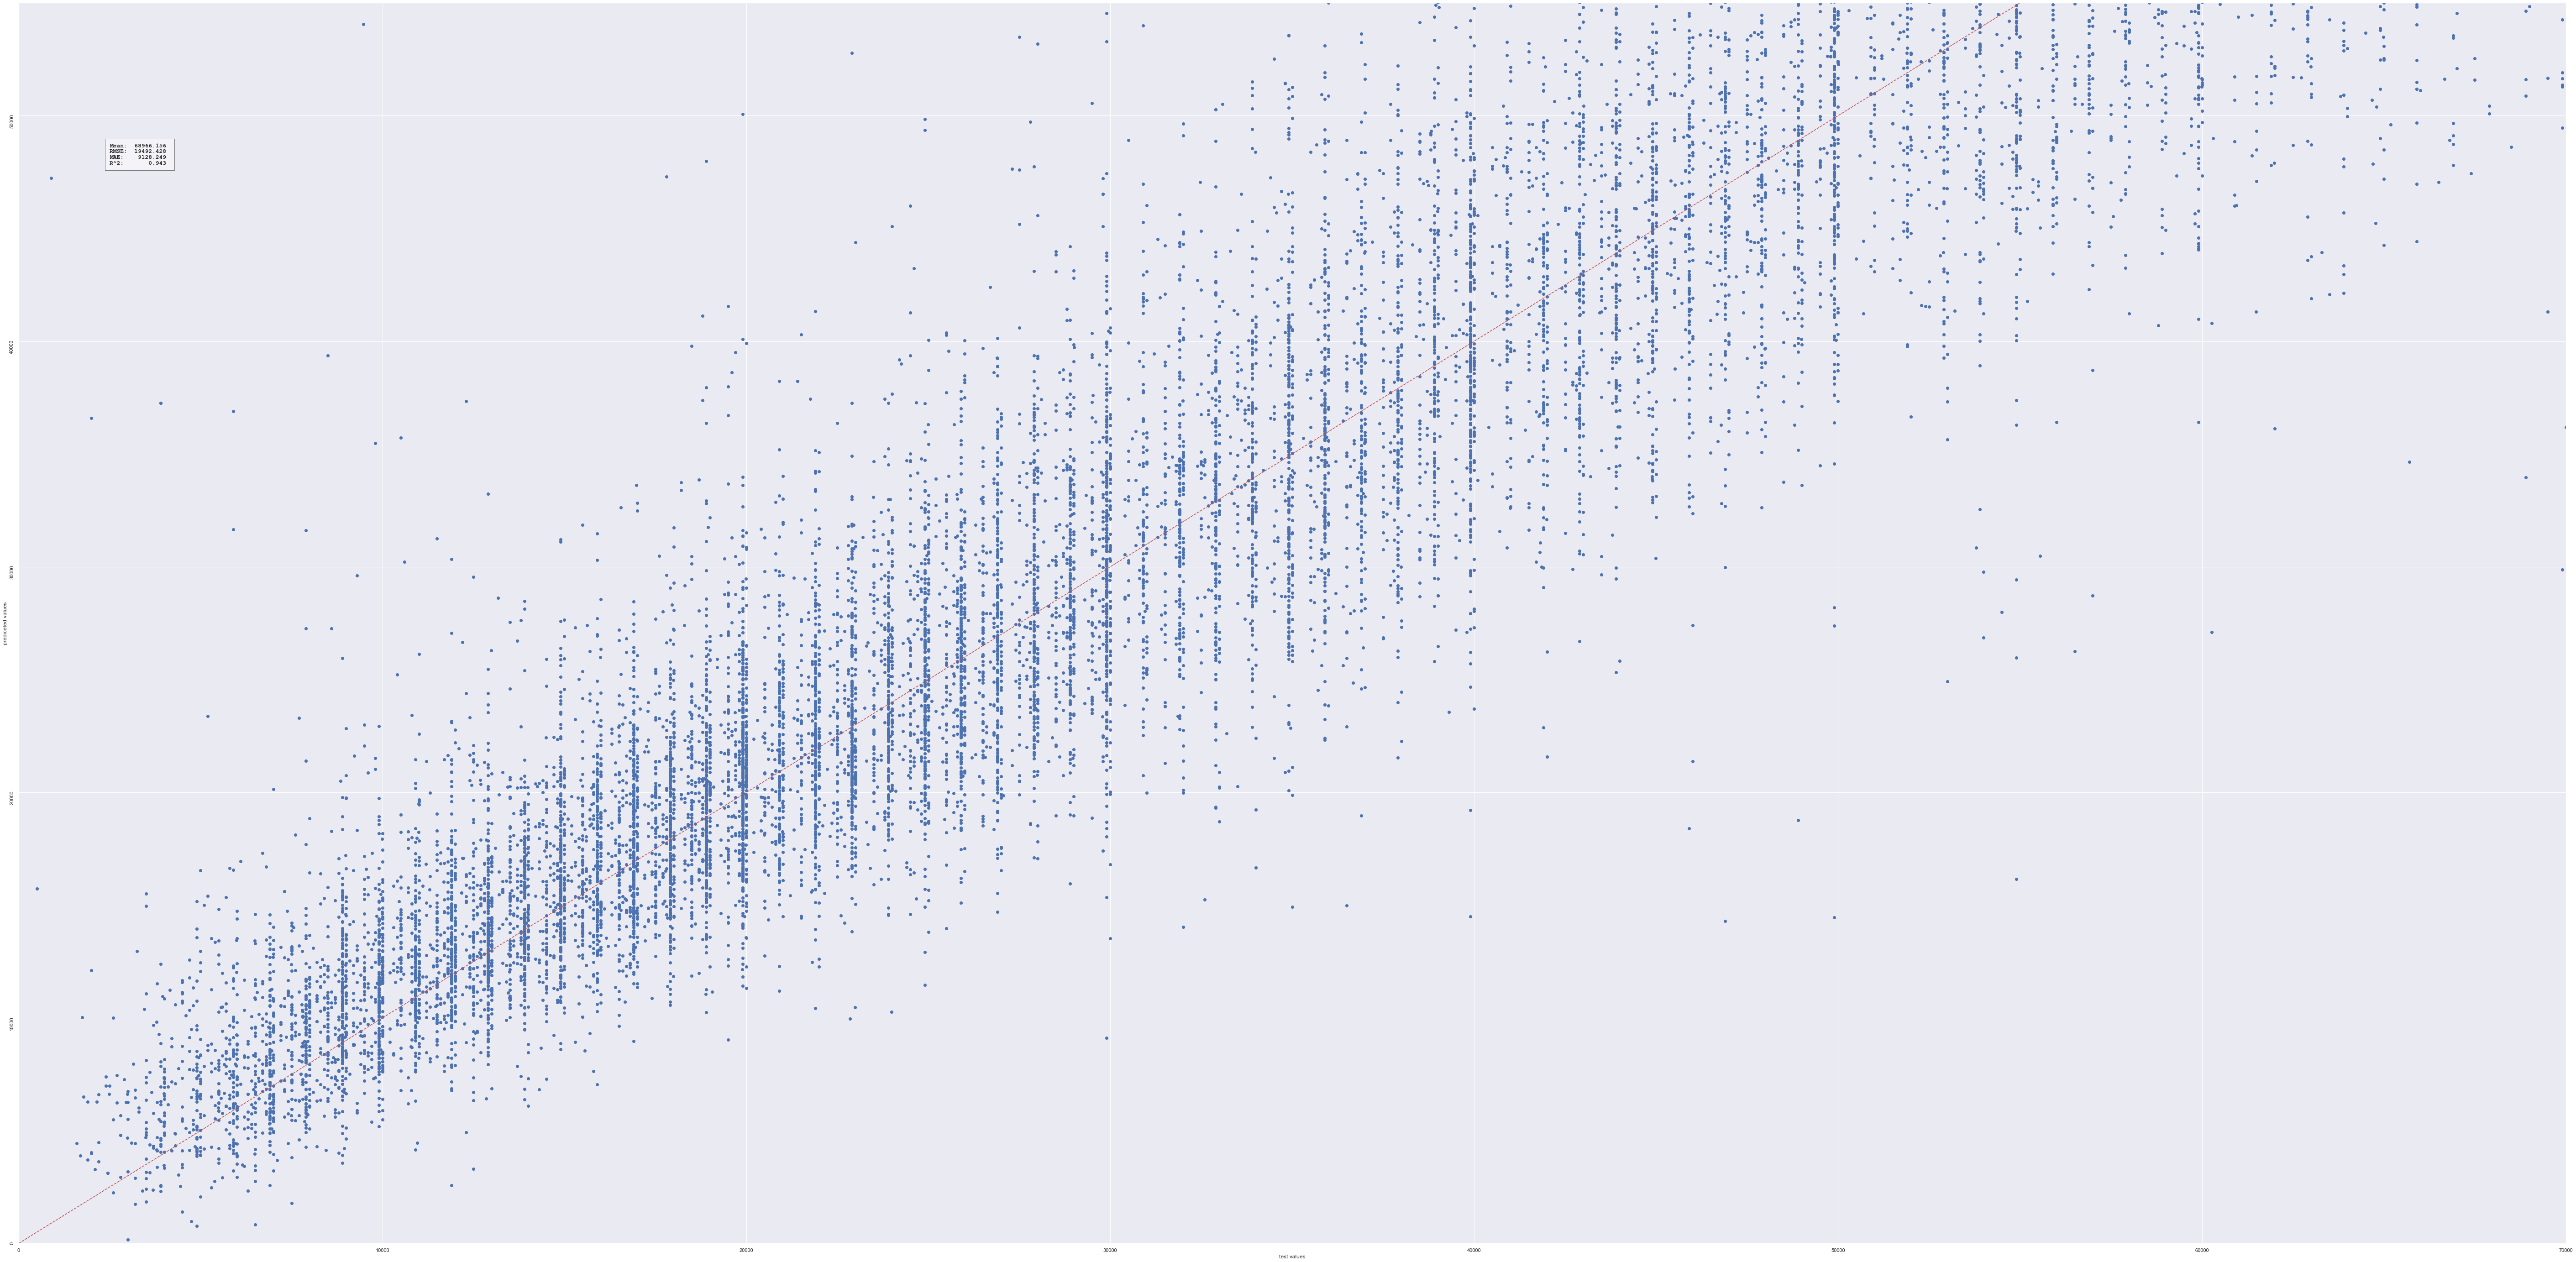

In [104]:
max = 55000
sns.set(rc={'figure.figsize':(100,50)})
plt.xlim(0,70000)
plt.ylim(0,max)
plt.scatter(y_test,y_pred)
plt.yticks(rotation="90")
plt.xlabel("test values")
plt.ylabel("prediceted values")
plt.plot([0,max],[0,max],'r--')
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
        #plt.title(str(title).upper(), font={'size':16})
t1, t2, t3, t4 = "Mean:", "RMSE:", "MAE:", "R^2:"
s1, s2, s3, s4 = format(y_pred.mean(),'.3f'), format(rmse,'.3f'), format(mae,'.3f'), format(r2,'.3f')
plt.annotate(f"{t1} {s1:>10} \n{t2} {s2:>10} \n{t3} {s3:>11} \n{t4} {s4:>11}", [2500,max*.87],
                            font={'size':13, 'family':'courier new', 'weight':'bold'},
                            bbox={'facecolor': 'white', 'edgecolor' : 'black', 'alpha': 0.5, 'pad': 10})
plt.show()

Dobranie najlepszych hiperparametrów dla XGBRegressor()

In [76]:
#RANDOMIZEDSEARCHCV - 'dart','gbtree'
params={
    "learning_rate" : [0.05,0.10,0.15,0.20],
    "max_depth" : [3,4,5,6,8] ,
    "colsample_bytree" : [0.5,0.7],
    "n_estimators" : [7,15,30,50,70,100,150,250],
    'gamma' : [0.01,0.1],
    
}
boo=['dart','gbtree']
for boost in boo:
    model_x3=xgb.XGBRegressor(booster=boost)
    random_search=RandomizedSearchCV(model_x3, param_distributions=params,random_state=42)
    random_search.fit(X_train, y_train)
    y_pred=random_search.predict(X_test)
    print('Score R2 : ',boost,random_search.score(X_test,y_test))
    rmse=np.sqrt(mean_squared_error(y_test,y_pred))
    mae=mean_absolute_error(y_test,y_pred)
    print('RMSE : ',boost,rmse)
    print('MAE',boost, mae)
    print('best_params: ',random_search.best_params_)
    print("================")

Score R2 :  dart 0.9278186996655936
RMSE :  dart 22116.410959850244
MAE dart 8699.299017104744
best_params:  {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 0.01, 'colsample_bytree': 0.5}
Score R2 :  gbtree 0.9254955255739216
RMSE :  gbtree 22469.503609703985
MAE gbtree 8610.88229396119
best_params:  {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 0.01, 'colsample_bytree': 0.5}


In [ ]:
# GRIDSEARCHCV -'dart','gbtree'
params={
    "learning_rate" : [0.05,0.10,0.15,0.20],
    "max_depth" : [3,4,5,6,8] ,
    "colsample_bytree" : [0.5,0.7],
    "n_estimators" : [70,100,150,250,350],
    "n_estimators" : [7,15,30,50,70,100,150,250,350],
    'gamma' : [0.01,0.1]


}
boo=['dart','gbtree']
l2=[]
for boost in boo:
    model_x3=xgb.XGBRegressor(booster=boost)
    gs=GridSearchCV(estimator=model_x3,
                param_grid=params,
                scoring=["r2","neg_root_mean_squared_error"],
                refit="r2",
                cv=5,n_jobs=6,
                verbose=4)

    gs.fit(X_train,y_train)
    y_predgs=gs.predict(X_test)
    gs.score(X_train,y_train)
    gs.score(X_test,y_test)
    r2 = r2_score(y_test, y_predgs)
    score=gs.score(X_test,y_test)
    rmse=np.sqrt(mean_squared_error(y_test,y_predgs))
    mae=mean_absolute_error(y_test,y_predgs)
    print('================================')
    print('Score : ', score)
    print('r2:  ', r2)
    print('RMSE:  ', rmse)
    print('MAE', mae)
    print('best_params: ',gs.best_params_)
    print('================================')
    l2.append([boost,'Score : ', score,'r2:  ', r2,'RMSE :  ', rmse,'MAE :', mae,'best_params: ',gs.best_params_, 'param_estimator',gs.best_estimator_])
    print(l2)

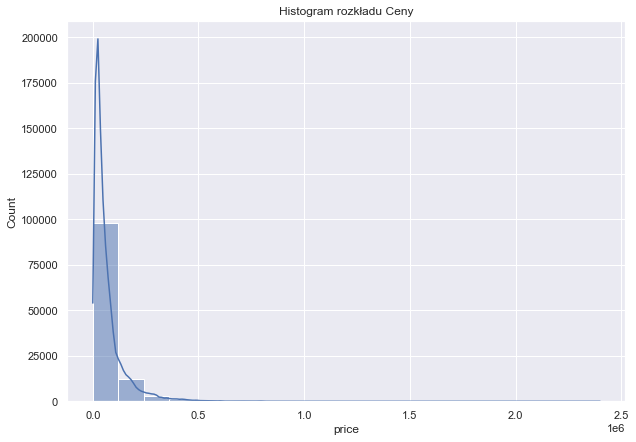

In [52]:
def price():
    rcParams['figure.figsize'] = 10, 7
    sns.histplot(data['price'], bins=20,kde=True)
    _ = plt.title("Histogram rozkładu Ceny")
price()

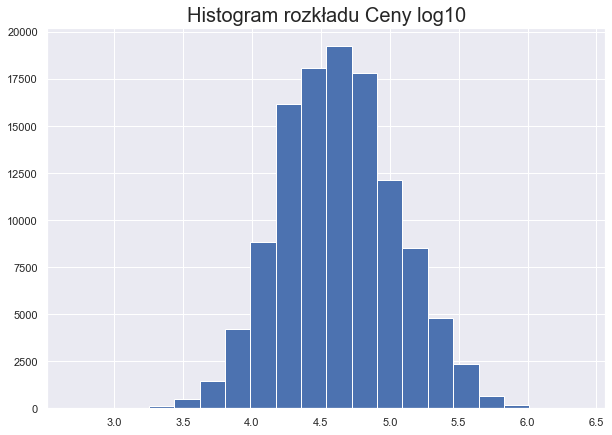

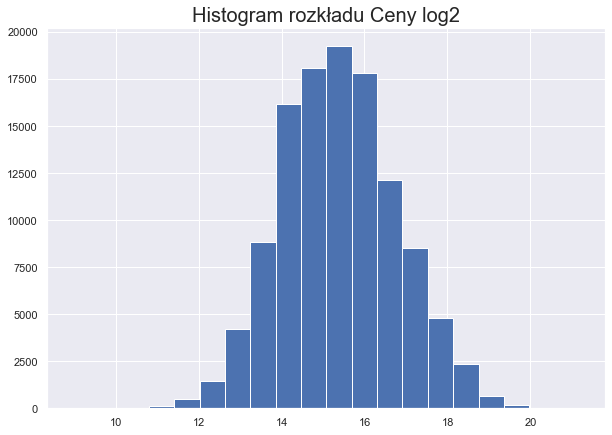

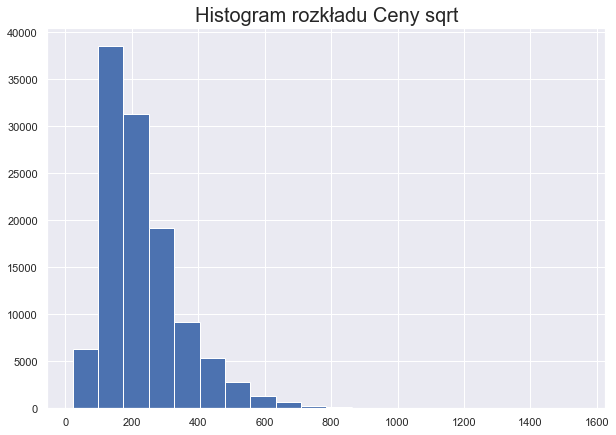

In [53]:
def hist_price():
    nums={'log10': np.log10, 'log2': np.log2,'sqrt': np.sqrt}
    for key , value in nums.items():
        a="Histogram rozkładu Ceny "+str(key)
        plt.hist(value(data['price']), bins=20)
        _ = plt.title(a, size=20)
        plt.show()
hist_price()

In [69]:
#log10
y_train_log=np.log10(y_train)
model_v1=xgb.XGBRegressor()
model_v1.fit(X_train,y_train_log)
y_pred_log=model_v1.predict(X_test)
y_pred_log=10**y_pred_log
r2 = r2_score(y_test, y_pred_log)
score=model_v1.score(X_test,y_test)
rmse=np.sqrt(mean_squared_error(y_test,y_pred_log))
mae=mean_absolute_error(y_test,y_pred_log)
print('Score : ', score)
print('r2', r2)
print('RMSE:  ', rmse)
print('MAE', mae)

Score :  -0.6952516969522615
r2 0.9385933979225557
RMSE:   20463.652624299328
MAE 9136.267457660782


In [70]:
y_train_sqrt=np.sqrt(y_train)

model_v2=xgb.XGBRegressor()
model_v2.fit(X_train,y_train_sqrt)
y_pred_sqrt=model_v2.predict(X_test)
y_pred_sqrt=y_pred_sqrt**2
score=model_v2.score(X_test,y_test)
rmse=np.sqrt(mean_squared_error(y_test,y_pred_sqrt))
mae=mean_absolute_error(y_test,y_pred_sqrt)
r2 = r2_score(y_test, y_pred_sqrt)
print('r2', r2)
print('Score : ', score)
print('RMSE:  ', rmse)
print('MAE', mae)

r2 0.9442061410882764
Score :  -0.6879958574230622
RMSE:   19506.027028262797
MAE 8831.166477013


In [94]:
#grind sqrt
params={
    "learning_rate" : [0.05,0.10,0.15,],
    "max_depth" : [3,4,,6,8] ,
    "colsample_bytree" : [0.5,0.7],
    "n_estimators" : [7,15,30,50,70,100,150],
    'gamma' : [0.01,0.1]
    
}
boo=['dart','gbtree']
l=[]
y_train_sqrt=np.sqrt(y_train)
for boost in boo:
    y_train_sqrt=np.sqrt(y_train)
    model_x3=xgb.XGBRegressor(booster=boost)
    gs=GridSearchCV(estimator=model_x3,
                param_grid=params,
                scoring=["r2","neg_root_mean_squared_error"],
                refit="r2",
                cv=5, n_jobs=8,
                verbose=4)

    gs.fit(X_train,y_train_sqrt)
    y_predgs_sqrt=gs.predict(X_test)
    y_predgs=y_predgs_sqrt**2
    gs.score(X_train,y_train)
    gs.score(X_test,y_test)
    score=gs.score(X_test,y_test)
    rmse=np.sqrt(mean_squared_error(y_test,y_predgs))
    mae=mean_absolute_error(y_test,y_predgs)
    print('================================')
    print('Score : ', score)
    print('RMSE:  ', rmse)
    print('MAE', mae)
    print('best_params: ',gs.best_params_)
    print('================================')
    l.append([boost,'Score : ', score,'RMSE :  ', rmse,'MAE :', mae,'best_params: ',gs.best_params_, 'params_estimator',gs.best_estimator_] )
    print(l)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
Score :  -0.6745637301153848
RMSE:   22020.589135615213
MAE 8416.717317292305
best_params:  {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.15, 'max_depth': 8, 'n_estimators': 150}
[['dart', 'Score : ', -0.6745637301153848, 'RMSE :  ', 22020.589135615213, 'MAE :', 8416.717317292305, 'best_params: ', {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.15, 'max_depth': 8, 'n_estimators': 150}, 'params_estimator', XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0.1, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.15, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=150, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
            

In [96]:
#grind sqrt
params={
    "learning_rate" : [0.05,0.10,0.15,],
    "max_depth" : [3,4,6,8] ,
    "colsample_bytree" : [0.5,0.7],
    "n_estimators" : [150,200,250],
    'gamma' : [0.01,0.1]
    
}
boo=['dart','gbtree']
l1=[]
y_train_sqrt=np.sqrt(y_train)
for boost in boo:
    y_train_sqrt=np.sqrt(y_train)
    model_x3=xgb.XGBRegressor(booster=boost)
    gs=GridSearchCV(estimator=model_x3,
                param_grid=params,
                scoring=["r2","neg_root_mean_squared_error"],
                refit="r2",
                cv=5, n_jobs=8,
                verbose=4)

    gs.fit(X_train,y_train_sqrt)
    y_predgs_sqrt=gs.predict(X_test)
    y_predgs=y_predgs_sqrt**2
    gs.score(X_train,y_train)
    gs.score(X_test,y_test)
    score=gs.score(X_test,y_test)
    rmse=np.sqrt(mean_squared_error(y_test,y_predgs))
    mae=mean_absolute_error(y_test,y_predgs)
    print('================================')
    print('Score : ', score)
    print('RMSE:  ', rmse)
    print('MAE', mae)
    print('best_params: ',gs.best_params_)
    print('================================')
    l1.append([boost,'Score : ', score,'RMSE :  ', rmse,'MAE :', mae,'best_params: ',gs.best_params_, 'params_estimator',gs.best_estimator_] )
    print(l1)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Score :  -0.6745544486356667
RMSE:   21927.215905597182
MAE 8165.199326407907
best_params:  {'colsample_bytree': 0.7, 'gamma': 0.01, 'learning_rate': 0.15, 'max_depth': 8, 'n_estimators': 250}
[['dart', 'Score : ', -0.6745544486356667, 'RMSE :  ', 21927.215905597182, 'MAE :', 8165.199326407907, 'best_params: ', {'colsample_bytree': 0.7, 'gamma': 0.01, 'learning_rate': 0.15, 'max_depth': 8, 'n_estimators': 250}, 'params_estimator', XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0.01, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.15, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=250, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
          

In [13]:
model_x1.save_model("model_car.json")